In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
import sys
import os
pwd = os.getcwd()
sys.path.append("/root/Gan/jidian/MLexperiments")
sys.path.append("/root/Gan/jidian")
sys.path.append(pwd)
sys.path.append(os.path.dirname(os.getcwd()))
import MLexperiments.classes
from MLexperiments.classes import ReadAutoLabeledData
import tensorflow as tf
import MLexperiments.config.parameters
from keras.layers import LSTM, Reshape
import matplotlib.pyplot as plt
import utils
import keras
from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import TensorBoard
from time import time
from keras.models import Model
from keras.layers import Input, Dense

import datetime

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5,6"

CLASSCOUNT = 2

FLAGS = None
myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.1, validation_size = 0.1)

(X_train, y_train), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

print(X_train[0].shape)
print(y_train[0])

X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_Ftest = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')

#X_train /= 255
#X_test /= 255



def tran_y(y):
    y_ohe = np.zeros(CLASSCOUNT)
    if y:
        y_ohe[1] = 1
    else:
        y_ohe[0] = 1
    return y_ohe
# def tran_y(y):
#     return y

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])
y_Ftest_ohe = np.array([tran_y(y_Ftest[i]) for i in range(len(y_Ftest))])



Using TensorFlow backend.


 np_input shape:  (49732, 100, 10) labelData shape:  (49732,)
read succesful
(1000,)
0


In [5]:
BATCH_SIZE=128

model = Sequential()
model.add(
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', input_shape=\
           (MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1),\
           activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])


In [6]:
# BATCH_SIZE=128

# a = Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN,\
#                                                                        MLexperiments.config.parameters.SAMPLE_HEIGHT, 1))
# #model.add(Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)))
# # model.add(
# #     Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),input_shape=(MLexperiments.config.parameters.SAMPLE_LEN,\
# #                                                                        MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)\
# #            , padding='valid', activation='relu',name="conv1"))

# # x =    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1)\
# #            , padding='valid', activation='relu',name="conv1")(a)
# x = Flatten()(a)

# x = Dense(2, activation='softmax', name = "dense3")(x)

# model = Model(inputs = [a], outputs = [x])

In [7]:


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
lossHistory = LossHistory()
checkpointer = ModelCheckpoint(filepath='/tmp/best_weights.hdf5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/{}".format(
datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S')),histogram_freq=1, batch_size=BATCH_SIZE, write_graph=True, write_grads=False, \
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.summary()
#



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 8, 64)         640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 8, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 6, 128)        73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 6, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 6, 32)         4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 4, 32)         9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 2, 16)         4624      
__________

In [8]:
history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=BATCH_SIZE, \
                callbacks=[\
                           lossHistory,\
                           checkpointer,\
                           tensorboard\
                          ] )

Train on 40283 samples, validate on 4475 samples
Epoch 1/5
40283/40283 [==============================] - 11s - loss: 0.3816 - acc: 0.8228 - val_loss: 0.2378 - val_acc: 0.9039
Epoch 2/5
40283/40283 [==============================] - 9s - loss: 0.1526 - acc: 0.9397 - val_loss: 0.1799 - val_acc: 0.9227
Epoch 3/5
40283/40283 [==============================] - 9s - loss: 0.1094 - acc: 0.9601 - val_loss: 0.0841 - val_acc: 0.9685
Epoch 4/5
40283/40283 [==============================] - 9s - loss: 0.0763 - acc: 0.9740 - val_loss: 0.0654 - val_acc: 0.9783
Epoch 5/5
40283/40283 [==============================] - 9s - loss: 0.0580 - acc: 0.9815 - val_loss: 0.1192 - val_acc: 0.9600


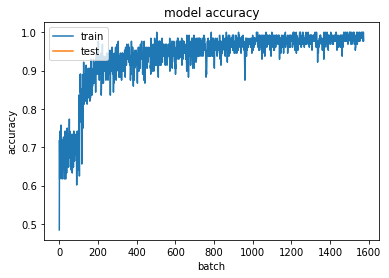

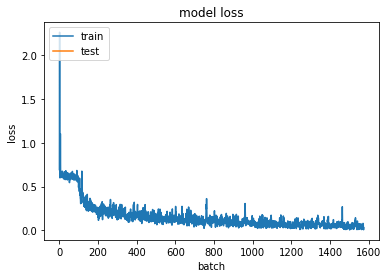

In [9]:

# summarize history for accuracy
plt.plot(lossHistory.acc)
plt.plot(lossHistory.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lossHistory.losses)
plt.plot(lossHistory.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

scores = model.evaluate(X_Ftest, y_Ftest_ohe, verbose=0)

expected: 0
prediction:0


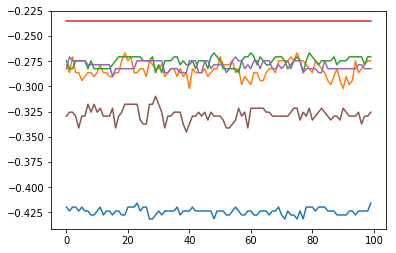

expected: 0
prediction:0


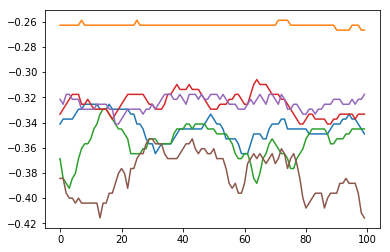

expected: 1
prediction:1


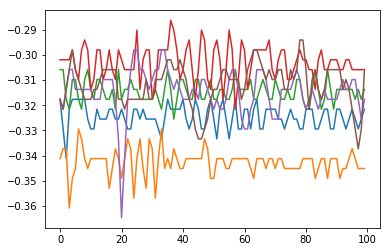

expected: 0
prediction:0


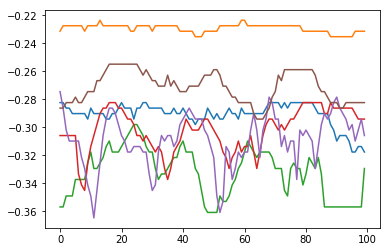

expected: 0
prediction:0


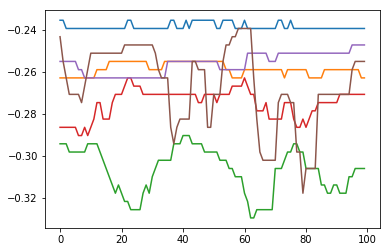

expected: 0
prediction:0


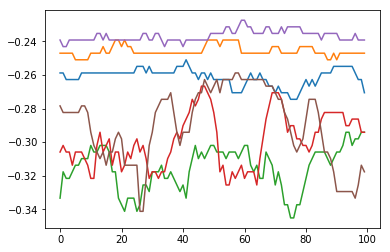

expected: 0
prediction:1


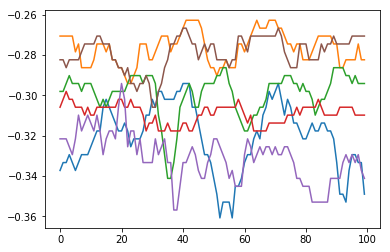

expected: 0
prediction:0


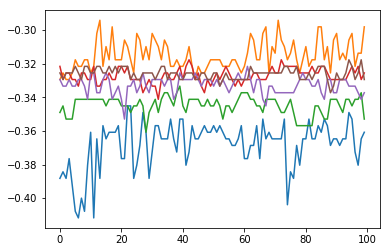

expected: 0
prediction:0


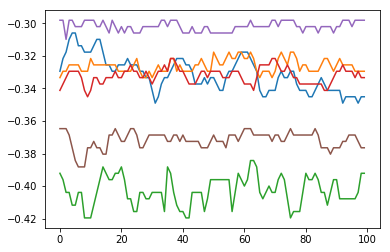

expected: 1
prediction:1


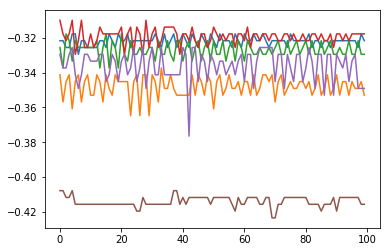

In [10]:

for index in range(10):
    print("expected: "+str( y_Ftest[index]))
    prediction = model.predict(np.expand_dims(X_Ftest[index], axis=0))[0]
    print("prediction:" + str(np.argmax(prediction,axis = 0)))
    time_series = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
        .astype('float32')[index]
    # plt.imshow( X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT).astype('float32')[0]);
    # plt.colorbar()
    # plt.show()
    plt.plot(time_series.T[0])
    plt.plot(time_series.T[1])
    plt.plot(time_series.T[2])
    plt.plot(time_series.T[3])
    plt.plot(time_series.T[4])
    plt.plot(time_series.T[5])
    plt.show()
   

In [2]:
import datetime

datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S')

NameError: name 'time' is not defined